In [1]:
import sys
sys.path.append('/home/jingpei/Desktop/CtRNet-robot-pose-estimation')

import multiprocessing as mp
import os
import time

from PIL import Image

import cv2
import numpy as np
import torch
from tqdm.notebook import tqdm

import torchvision
import matplotlib.pyplot as plt
import glob

from imageloaders.DREAM import ImageDataLoaderSynthetic, LabelGenerator


from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import kornia


from utils import *



In [2]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.n_kp = 12
args.scale = 0.5
args.lim=[-1., 1., -1., 1.]
args.height = 480 
args.width = 640
args.base_dir = '/home/jingpei/Desktop/CtRNet-robot-pose-estimation'
#args.data_folder = '/media/jingpei/DATA/DREAM/data/synthetic/panda_synth_train_dr'
args.data_folder = '/media/jingpei/DATA/DREAM/data/synthetic/panda_synth_test_photo'

args.use_gpu = True
args.batch_size = 4

if args.use_gpu:
    device = "cuda"
else:
    device = "cpu"


args.fx = -320.
args.fy = -320.
args.px = 320.
args.py = 240.
# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale
intrinsics = np.array([[  args.fx   ,    0.        ,  args.px  ],
                       [  0.        ,    args.fy   ,  args.py  ],
                       [  0.        ,    0.        ,   1.      ]])

K = torch.tensor(intrinsics, device=device, dtype=torch.float)


In [4]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#torch.multiprocessing.set_start_method('spawn')

#dataset = ImageDataLoader(data_file = args.data_file, data_dir = args.data_dir, trans_to_tensor = trans_to_tensor)
#dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers= 6, shuffle=True)
dataset = ImageDataLoaderSynthetic(data_folder = args.data_folder, scale = args.scale, trans_to_tensor = trans_to_tensor)
dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers= 6, shuffle=True)
labelgenerator = LabelGenerator(args, args.data_folder)

In [5]:
len(labelgenerator.ndds_dataset)

5997

In [6]:
for i in tqdm(range(len(labelgenerator.ndds_dataset))):
    labelgenerator.generate_mask(i)
    labelgenerator.generate_keypoints(i)


  0%|          | 0/5997 [00:00<?, ?it/s]

# generate ground truth

In [6]:
from models.robot_arm import PandaArm
from models.BPnP import batch_project
robot = PandaArm(urdf_file = os.path.join(args.base_dir,"urdfs/Panda/panda.urdf"))

In [8]:
data = next(iter(dataloader))
#data = dataset.__getitem__(0)

if args.use_gpu:
    if isinstance(data, list):
        data = [d.cuda() for d in data]
    else:
        data = data.cuda()

img, joint_angle, base_to_cam, keypoints, mask = data

In [10]:
# generate ground truth

#mask_list_gt = list()
points_2d_gt_list = list()
points_3d_list = list()
for b in range(img.shape[0]):
    #baxter_mesh = panda_renderer.get_robot_mesh(joint_angle[b].cpu().squeeze())
    #rendered_image = panda_renderer.silhouette_renderer(meshes_world=baxter_mesh, R = base_to_cam[b,:3,:3].T.unsqueeze(0), T = base_to_cam[b,:3,3].unsqueeze(0))
    #mask_list_gt.append(rendered_image[..., 3])

    points = robot.get_3d_keypoints(joint_angle[b].cpu().squeeze())
    points_3d = torch.from_numpy(points).float().to(device)
    points_3d_list.append(points_3d[None])
    points_2d_gt = batch_project(base_to_cam[b,:3,:4][None], points_3d, K, angle_axis=False)
    points_2d_gt_list.append(points_2d_gt)


#mask_batch = torch.cat(mask_list_gt,0)
points_2d_gt_batch = torch.cat(points_2d_gt_list,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


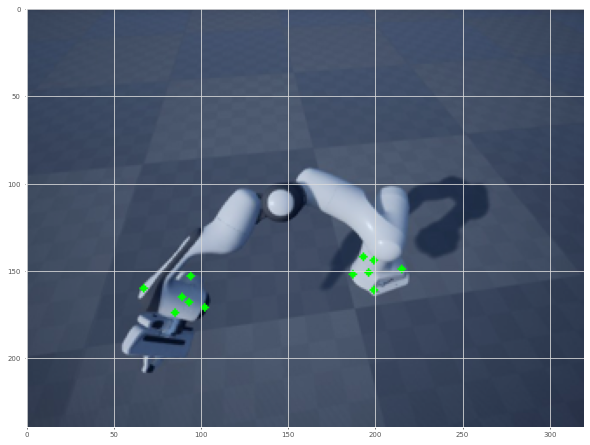

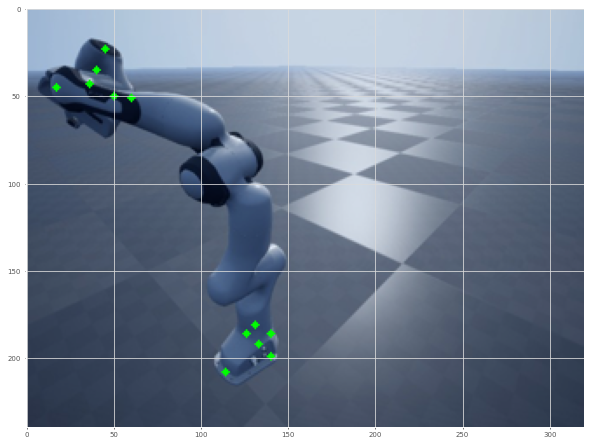

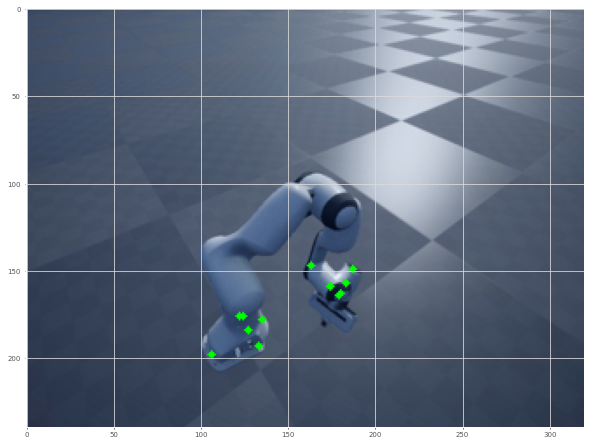

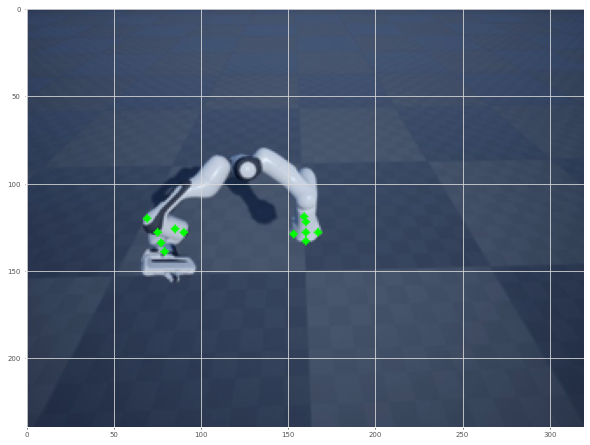

In [20]:
for b in range(img.shape[0]):
    img_np = to_numpy_img(img[b])
    img_np = overwrite_image(img_np,points_2d_gt_batch[b].detach().cpu().numpy().squeeze().astype(int), color=(0,255,0),point_size=2)
    # set size
    plt.figure(figsize=(10,10))
    plt.imshow(img_np)


In [15]:
from models.BPnP import BPnP_m3d
bpnp = BPnP_m3d.apply

In [16]:
bpnp(points_2d_gt_batch, torch.cat(points_3d_list,0),K)

tensor([[-9.5763e-01,  1.6895e+00,  1.5237e+00,  1.3000e-01, -3.7306e-01,
          8.7731e-01],
        [-1.6657e+00,  2.1594e+00,  6.2752e-01,  6.7757e-02, -3.4390e-04,
          1.2897e+00],
        [-4.8991e-01,  2.7728e+00,  1.0781e+00,  2.4455e-01, -1.9925e-01,
          1.2145e+00],
        [-2.3749e+00,  1.0020e+00,  3.0720e-01, -1.7929e-01, -7.8599e-02,
          1.3783e+00]], device='cuda:0')

In [17]:
base_to_cam

tensor([[[-5.1350e-01, -8.5810e-01, -0.0000e+00,  1.3000e-01],
         [-8.8400e-02,  5.2900e-02,  9.9470e-01, -3.7308e-01],
         [-8.5350e-01,  5.1080e-01, -1.0300e-01,  8.7729e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-2.5410e-01, -9.6720e-01, -0.0000e+00,  6.7735e-02],
         [-8.1650e-01,  2.1450e-01,  5.3610e-01, -3.4200e-04],
         [-5.1850e-01,  1.3620e-01, -8.4420e-01,  1.2899e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-9.3950e-01, -3.4250e-01, -0.0000e+00,  2.4458e-01],
         [-2.5250e-01,  6.9270e-01,  6.7560e-01, -1.9928e-01],
         [-2.3140e-01,  6.3470e-01, -7.3730e-01,  1.2147e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 6.9770e-01, -7.1640e-01, -0.0000e+00, -1.7927e-01],
         [-5.9370e-01, -5.7820e-01,  5.5960e-01, -7.8583e-02],
         [-4.0090e-01, -3.9040e-01, -8.2880e-01,  1.3782e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

# shared encoder

In [24]:
from models.keypoint_seg_resnet import KeyPointSegNet

keypoint_seg_predictor = KeyPointSegNet(args, use_gpu=args.use_gpu)
if args.use_gpu:
    keypoint_seg_predictor = keypoint_seg_predictor.cuda()


In [41]:
data = next(iter(dataloader))

if args.use_gpu:
    if isinstance(data, list):
        data = [d.cuda() for d in data]
    else:
        data = data.cuda()

img, joint_angle, base_to_cam, points_2d_gt_batch, mask_batch = data

In [42]:
heatmap, segmentation = keypoint_seg_predictor(img)
heatmap.shape

torch.Size([4, 12, 240, 320])

In [43]:
segmentation.shape

torch.Size([4, 1, 240, 320])

In [44]:
mask_batch.shape

torch.Size([4, 240, 320])

In [45]:
points_2d_gt_batch.shape

torch.Size([4, 12, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'GT mask')

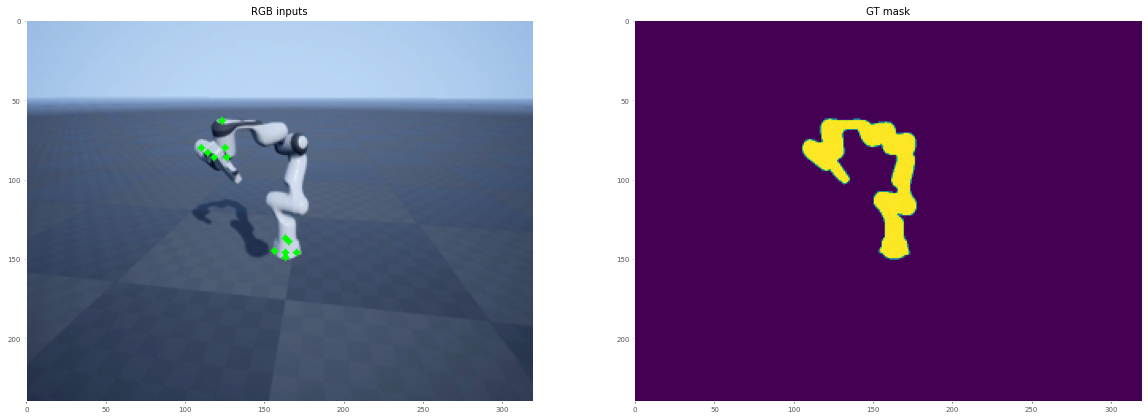

In [47]:
plt.figure(figsize=(20, 10))
idx = 0


img_np = to_numpy_img(img[idx])
img_np = overwrite_image(img_np,points_2d_gt_batch[idx].detach().cpu().numpy().squeeze().astype(int), color=(0,255,0),point_size=2)

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.grid(False)
plt.title("RGB inputs")

plt.subplot(1, 2, 2)
plt.imshow(mask_batch[idx].squeeze().cpu().detach().numpy())
plt.grid(False)
plt.title("GT mask")

In [48]:
from models.heatmap import GaussianHeatmapLoss
heatmap_loss = GaussianHeatmapLoss()
heatmap_loss.cuda()

Gaussian Heatmap Loss with std=1.5 and landmark_downscale=1

In [49]:
loss, target_heatmap = heatmap_loss(heatmap, points_2d_gt_batch)

/home/jingpei/anaconda3/envs/pytorch_ros/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [56]:
loss

tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

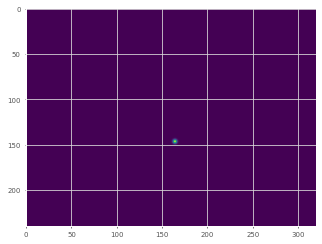

In [51]:
plt.imshow(to_numpy_img(target_heatmap[0,0]))

In [52]:
len(target_heatmap[0,0].shape)

2

In [53]:
criterionBCE = torch.nn.BCEWithLogitsLoss()

criterionBCE(segmentation.squeeze(), mask_batch)

tensor(0.5815, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [54]:
segmentation.squeeze().shape

torch.Size([4, 240, 320])